# Germany Inc Shareholders - Consolidation

## Table of contents

[I. Loading the data](#section_id1)  
[II. Preprocessing](#section_id2)  
&nbsp;&nbsp;&nbsp;&nbsp;[1. Overview](#section_id3)  
&nbsp;&nbsp;&nbsp;&nbsp;[2. Preprocessing steps](#section_id4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[a. Data cleaning](#section_id5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[b. Using information already collected elsewhere in the project](#section_id6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[c. Establishing a ground truth](#section_id7)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[aa. Reconciling data with the OpenCorporates Reconciliation API](#section_id8)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[bb. Retrieving previous company names from OpenCorporates](#section_id9)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[cc. Distinguishing between legal entities and natural persons using GPT3.5-turbo](#section_id10)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[dd. Matching notifying parties using GPT3.5-turbo](#section_id11)  

<a id='section_id1'></a>

## I. Loading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('../data/mydata.csv', low_memory=False)
# Print the first few rows of the data
df.head()

,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
0,1,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,ROTHENBERGER Vermögensverwaltung GbR 4xS,NaN,29.62,NaN,NaN,1999-05-11,29.62,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1,2,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,"Rothenberger, Dr., Helmut",NaN,11.93,NaN,NaN,1995-10-07,11.93,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
2,3,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,"Schneider, Franz Jürgen",NaN,33.10,NaN,NaN,1998-07-08,33.10,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
4,5,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Deutschland Gesellschaft für Industriebetei...,NaN,23.34,NaN,NaN,1998-07-08,23.34,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0


<a id='section_id2'></a>

## II. Preprocessing

<a id='section_id3'></a>

### 1. Overview

In order to implement any of the rules, we need to consolidate the list of shareholders. First, I will group all entries by exact matches and sort them from the largest to smallest group. Then, I will create a plot that shows the first 100 rows of that sorted dataframe.



14457


,notifying_party,counts
1858,"BlackRock, Inc.",9412
1172,Axxion S.A.,4951
3201,DWS Investment GmbH,4218
822,Allianz Global Investors GmbH,3636
12661,"The Capital Group Companies, Inc.",3251
13072,Universal-Investment-Gesellschaft mit beschrän...,3142
1392,Baden-Württembergische Versorgungsanstalt für ...,2926
7451,LBBW Asset Management Investmentgesellschaft mbH,2740
1846,"BlackRock Holdco 2, Inc.",2735
14169,"Zours, Wilhelm Konrad Thomas",2609


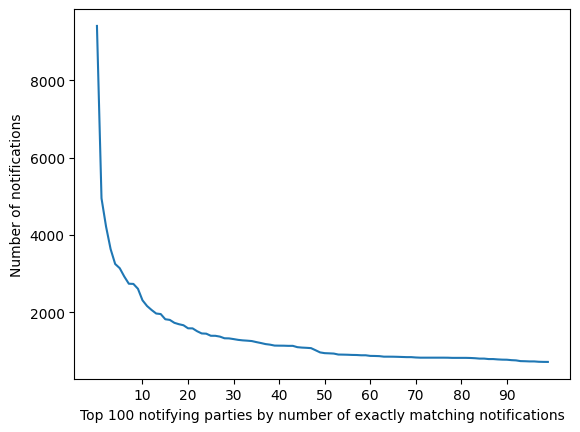

In [2]:
# group by notifying party and aggregate the number of entries
df_grouped = df.groupby(['notifying_party']).size().reset_index(name='counts')
print(len(df_grouped))
# sort this dataframe by the number of entries
df_grouped = df_grouped.sort_values(by=['counts'], ascending=False)
# plot only every 100th entry to generate it faster
sns.lineplot(x='notifying_party', y='counts', data=df_grouped[:100])

# Set custom x-axis and y-axis labels
plt.xlabel('Top 100 notifying parties by number of exactly matching notifications')
plt.ylabel('Number of notifications')

# Set custom x-axis tick locations and labels
tick_locations = range(10, 100, 10)
tick_labels = [str(i) for i in tick_locations]

plt.xticks(tick_locations, tick_labels)

df_grouped.head(20)


Among the shareholders with the highest numbers of records, there is a high number of asset managers. The largest groups also account for the bulk of the overall number of records. This can also be spot-checked by inserting a statement like df_grouped['counts'].iloc[some index, like 5846 or 11937 or 14101] below the line where dataframe is sorted.

<a id='section_id4'></a>

### 2. Preprocessing steps

To consolidate the the data, we first need to ensure that each notifying party does not appear as two or more seemingly distinct entities in the data. Firstly, we will therefore focus on consolidating the unique values in the notifying_party column.

In [3]:
# create a dataframe with just the unique notifying parties
unique_notifying_parties = df.drop_duplicates(subset=['notifying_party'], keep='first')

# drop all other columns
unique_notifying_parties = unique_notifying_parties[['notifying_party']]

# add a unique id as the first column
unique_notifying_parties.insert(0, 'id', range(0, len(unique_notifying_parties)))
unique_notifying_parties

,id,notifying_party
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS
1,1,"Rothenberger, Dr., Helmut"
2,2,"Schneider, Franz Jürgen"
3,3,3i Group plc
4,4,3i Deutschland Gesellschaft für Industriebetei...
...,...,...
1113438,14453,"Hagemann, Hanno"
1113798,14454,"Krüper, Sebastian"
1114109,14455,"Müller, Tarek"
1114384,14456,"Riemer, Frank"


<a id='section_id5'></a>

#### a. Data cleaning

Before properly working with the data, I applied some simple cleaning rules with regex:

In [4]:
import re

def clean_name(name):
    if type(name) == str:
        name = name.lower()
        name = re.sub('aktiengesellschaft', 'ag', name)
        name = re.sub('kommanditgesellschaft auf aktien', 'kgaa', name)
        name = re.sub('kommanditgesellschaft', 'kg', name)
        name = re.sub('gesellschaft mit beschränkter haftung', 'gmbh', name)
        name = re.sub('limited', 'ltd', name)
        name = re.sub('mit beschränkter haftung', 'gmbh', name)
        name = re.sub('société anonyme', 'sa', name)
        name = re.sub('public limited company', 'plc', name)
        name = re.sub('sociedad anónima', 'sa', name)
        name = re.sub('naamloze vennootschap', 'nv', name)
        name = re.sub('besloten vennootschap', 'bv', name)
        name = re.sub('société à responsabilité limitée', 'sarl', name)
        name = re.sub('incorporated', 'inc', name)
        name = re.sub('corporation', 'corp', name)
        name = re.sub('company', 'co', name)
        name = re.sub('joint stock company', 'jsc', name)
        name = re.sub('sociedad limitada', 'sl', name)
        name = re.sub('public joint stock company', 'pjsc', name)
        name = re.sub('closed joint stock company', 'cjsc', name)
        name = re.sub('open joint stock company', 'ojsc', name)
        name = re.sub('limited liability company', 'llc', name)
        name = re.sub('limited partnership', 'lp', name)
        name = re.sub('&', 'und', name)
        name = re.sub('ß', 'ss', name)
        name = re.sub('ö', 'oe', name)
        name = re.sub('ü', 'ue', name)
        name = re.sub('ä', 'ae', name)
        name = re.sub('i\.l\.', '', name)
        name = re.sub('i\.k\.', '', name)
        name = re.sub('i\.a\.', '', name)
        name = re.sub('i\.a', '', name)
        name = re.sub('\-', '', name)
        name = re.sub('\:', '', name)
        name = re.sub('_', '', name)
        name = re.sub('\+', '', name)
        name = re.sub(',', '', name)
        name = re.sub('\?', '', name)
        name = re.sub("'", '', name)
        name = re.sub('\.', '', name)
        name = re.sub('/', '', name)
        name = re.sub('!', '', name)
        name = re.sub('<', '', name)
        name = re.sub('>', '', name)
        name = re.sub('"', '', name)
        name = re.sub('„', '', name)
        name = re.sub('“', '', name)
        name = re.sub('”', '', name)
        name = re.sub('·', '', name)
        name = name.strip()
    return name


Adding these cleaned names as a new column:

In [5]:
# add a new column to unique_notifying_parties that applies the clean_name function to the notifying_party column
unique_notifying_parties['cleaned_name'] = unique_notifying_parties['notifying_party'].apply(clean_name)
unique_notifying_parties.head()

,id,notifying_party,cleaned_name
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut
2,2,"Schneider, Franz Jürgen",schneider franz juergen
3,3,3i Group plc,3i group plc
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...


We can now assign all the spellings an ID based on the cleaned version of their spelling, ```preprocessed-id```:

In [6]:
# Initialize a dictionary to store the mapping of cleaned names to IDs
name_to_id = {}
current_id = 1

# Iterate over the DataFrame rows
for index, row in unique_notifying_parties.iterrows():
    cleaned_name = row['cleaned_name']

    # If the cleaned_name is not already in the dictionary, assign a new ID
    if cleaned_name not in name_to_id:
        name_to_id[cleaned_name] = current_id
        current_id += 1

    # Assign the ID to the 'preprocessed_id' column
    unique_notifying_parties.at[index, 'preprocessed_id'] = name_to_id[cleaned_name]

unique_notifying_parties.head()

,id,notifying_party,cleaned_name,preprocessed_id
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0
3,3,3i Group plc,3i group plc,4.0
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0


<a id='section_id6'></a>

#### b. Using information already collected elsewhere in the project

From the "Key" part of the Germany Inc. project, we already have a list that contains all spellings of the companies as they appear in the "issuers" column. Spellings that belong to one company have been assigned the same `company_id`. Since this dataframe does not only focus on different spellings, but on different spelling-ISIN combinations, the same spellings appear multiple times. To get a list of all unique spellings, we will drop duplicates on the `name` column:

In [7]:
df_dba_spellings = pd.read_csv('../data/names.csv')
print(len(df_dba_spellings))
df_dba_spellings.drop_duplicates(subset=['name'], inplace=True)
df_dba_spellings.head()

17821


,Unnamed: 0,wkn,name,isin,ag,id,company_id
0,1,121806,Altira Aktiengesellschaft,DE0001218063,altiraag,1,1
1,2,121806,FinLab AG,DE0001218063,finlabag,1,1
2,3,121806,Themis Capital Group AG,NaN,themiscapitalgroupag,1,1
3,4,126174,UTIMACO Safeware Aktiengesellschaft,DE0001261741,utimacosafewareag,2,2
4,5,126174,Utimaco Safeware AG,DE0001261741,utimacosafewareag,2,2


To find alias groups in our dataframe of different spellings of issuers, we will join `df_dba_spellings` on the `notifying_party` column of the `unique_notifying_parties`. Now, we can filter for records that were successfully matched, i.e. where `company_id` is not NaN and group these records by `company_id` to see which companies have how many aliases present in their data:

In [8]:
unique_notifying_parties_with_company_id_notna = unique_notifying_parties.merge(
    df_dba_spellings,
    left_on='notifying_party',
    right_on='name',
    how='left'
).dropna(subset=['company_id'])

print("Number of matched records from unique_notifying_parties:", len(unique_notifying_parties_with_company_id_notna))


# group by company_id and aggregate the number of entries
df_grouped = unique_notifying_parties_with_company_id_notna.groupby(['company_id']).size().reset_index(name='counts')
df_grouped.head()

Number of matched records from unique_notifying_parties: 666


,company_id,counts
0,1.0,2
1,4.0,1
2,5.0,5
3,6.0,3
4,8.0,1


The following bar chart indicates how often alias groups of size n=1, 2, 3, 4 and 5 appear:

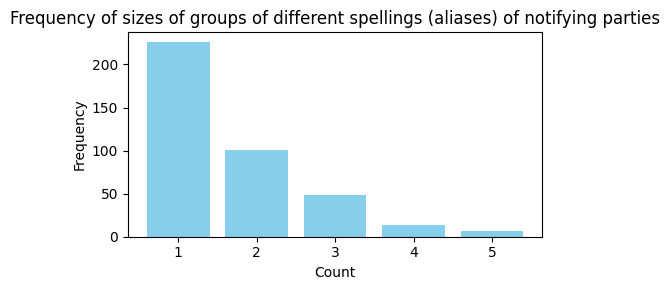

In [9]:
# Calculate the histogram of 'counts'
hist_counts = df_grouped['counts'].value_counts().reset_index().sort_values(by='index')

# Create the bar chart
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.bar(hist_counts['index'], hist_counts['counts'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Frequency of sizes of groups of different spellings (aliases) of notifying parties')
plt.xticks(hist_counts['index'])  # Set x-axis ticks to the unique count values

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
# merge df-dba-spellings with unique_notifying_parties
unique_notifying_parties = unique_notifying_parties.merge(
    df_dba_spellings[['name', 'company_id']],
    left_on='notifying_party',
    right_on='name',
    how='left'
)

unique_notifying_parties

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN
3,3,3i Group plc,3i group plc,4.0,NaN,NaN
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN
...,...,...,...,...,...,...
14453,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN
14454,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN
14455,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN
14456,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN


Assigning all rows an ID based on the Key Identity data (```key-identity-based-id```):

In [11]:
# Initialize a dictionary to store the mapping of company_id to IDs
company_id_to_id = {}
current_id = 1

# Create a new column 'key-identity-based-id' initialized with None
unique_notifying_parties['key-identity-based-id'] = None

# Iterate over the DataFrame rows
for index, row in unique_notifying_parties.iterrows():
    company_id = row['company_id']

    # If the company_id is not already in the dictionary, assign a new ID
    if company_id not in company_id_to_id:
        company_id_to_id[company_id] = current_id
        current_id += 1

    # Assign the ID to the 'key-identity-based-id' column
    unique_notifying_parties.at[index, 'key-identity-based-id'] = company_id_to_id[company_id]

unique_notifying_parties

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5
...,...,...,...,...,...,...,...
14453,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185
14454,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186
14455,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187
14456,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188


#### Create OpenCorporates-based key

Next, we will reconcile based on the results we get from querying the OpenCorporates API with the original spellings of the notifying parties. This is the first of two options to pursue, with the second one being that the legal entity types are left out completely, which leads to correct matches not established with this approach, but also more ambiguity.

In [12]:
full_oc_data = pd.read_csv('../data/231226_oc_data_full.csv')

# keep one record per id, if it has a score above n
n = 30

full_oc_data = full_oc_data.sort_values(by=['score'], ascending=False).groupby('original_id').head(1)
full_oc_data = full_oc_data[full_oc_data['score'] >= n]

# sort by original_id
full_oc_data = full_oc_data.sort_values(by=['original_id'])
full_oc_data

,original_id,api_id,name,type-id,type-organization,score,match,uri
0,3,/companies/gb/01142830,3I GROUP PLC,/organization/organization,Organization,56.0,False,https://opencorporates.com/companies/gb/01142830
15,4,/companies/de/M1201_HRB26172,3i Deutschland Gesellschaft für Industriebetei...,/organization/organization,Organization,52.0,False,https://opencorporates.com/companies/de/M1201_...
17,9,/companies/dk/35447423,Assicurazioni Generali S.p.A,/organization/organization,Organization,31.2,False,https://opencorporates.com/companies/dk/35447423
33,11,/companies/de/R3306_HRB104939,Akzo Nobel GmbH,/organization/organization,Organization,52.0,False,https://opencorporates.com/companies/de/R3306_...
289,16,/companies/us_fl/Q98000000031,BHF-BANK AKTIENGESELLSCHAFT,/organization/organization,Organization,50.0,False,https://opencorporates.com/companies/us_fl/Q98...
...,...,...,...,...,...,...,...,...
190607,14433,/companies/fr/388555021,CREDIT MUTUEL ASSET MANAGEMENT,/organization/organization,Organization,55.0,False,https://opencorporates.com/companies/fr/388555021
190609,14439,/companies/de/D2601V_HRB177839,Wacker Neuson SE,/organization/organization,Organization,57.2,False,https://opencorporates.com/companies/de/D2601V...
190610,14441,/companies/ca_nb/662760,Cinven Capital Management (V) General Partner ...,/organization/organization,Organization,52.0,False,https://opencorporates.com/companies/ca_nb/662760
190617,14447,/companies/nz/1964756,PIE FUNDS MANAGEMENT LIMITED,/organization/organization,Organization,55.0,False,https://opencorporates.com/companies/nz/1964756


This data is correct, but it disregards the jurisdictions of the companies. Often wrong jurisdictions are picked because a company has a branch office there. In the following, we will assume that the legal form (Rechtsform?) of the company indicates its home jurisdiction. We will have the assessment done by GPT-3.5-turbo.

In [13]:
def extract_first_two_letters(text):
    # Split the text and extract the substring between the second and third slash
    parts = text.split('/')
    return parts[2][:2] if len(parts) >= 3 else None

# Apply the function and remove duplicates in one step
extracted_list = list(set(full_oc_data['api_id'].apply(extract_first_two_letters)))

# Display the result
extracted_list


['ug',
 'im',
 'tz',
 'ro',
 'nl',
 'is',
 'bs',
 'cy',
 'je',
 'gr',
 'se',
 'vu',
 'bm',
 'my',
 'no',
 'ca',
 'mu',
 'de',
 'za',
 'au',
 'bz',
 'gg',
 'mt',
 'cw',
 'br',
 'li',
 'ch',
 'lu',
 'in',
 'jp',
 'bb',
 'us',
 'fi',
 'dk',
 'bd',
 'ae',
 'bh',
 'ie',
 'gi',
 'do',
 'es',
 'pl',
 'fr',
 'sg',
 'be',
 'nz',
 'gb',
 'hk',
 'pa']

Based on this, we can create a dictionary with the full country names and their country codes that have appeared in the response to our API calls made earlier. The full list of country codes can be retrieved via calling ```https://api.opencorporates.com/v0.4/jurisdictions?api_token=your_api_token```, where api_token is your API token. For the sake of reproducibility, we have made the full list available here.

In [14]:
country_codes = {
    'Australia': 'au', 'Bahamas': 'bs', 'Bahrain': 'bh', 'Bangladesh': 'bd', 'Barbados': 'bb',
    'Belgium': 'be', 'Belize': 'bz', 'Bermuda': 'bm', 'Brazil': 'br', 'Canada': 'ca',
    'Curaçao': 'cw', 'Cyprus': 'cy', 'Denmark': 'dk', 'Dominican Republic': 'do', 'Finland': 'fi',
    'France': 'fr', 'Germany': 'de', 'Gibraltar': 'gi', 'Greece': 'gr', 'Guernsey': 'gg',
    'Hong Kong': 'hk', 'Iceland': 'is', 'India': 'in', 'Ireland': 'ie', 'Isle of Man': 'im',
    'Japan': 'jp', 'Jersey': 'je', 'Liechtenstein': 'li', 'Luxembourg': 'lu', 'Malaysia': 'my',
    'Malta': 'mt', 'Mauritius': 'mu', 'Netherlands': 'nl', 'New Zealand': 'nz', 'Norway': 'no',
    'Panama': 'pa', 'Poland': 'pl', 'Romania': 'ro', 'Singapore': 'sg', 'South Africa': 'za',
    'Spain': 'es', 'Sweden': 'se', 'Switzerland': 'ch', 'Tanzania': 'tz', 'Uganda': 'ug',
    'United Arab Emirates': 'ae', 'United Kingdom': 'gb', 'United States': 'us', 'Vanuatu': 'vu'
}


In the following, we will give all the names to GPT and have it determine the origin country of each legal entity.

In [15]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=api_key)

def call_language_model(client, system_prompt, user_prompt, full_text):
    """
    Makes a call to the GPT language model and returns the response and the cost.

    Parameters:
    client (obj): The GPT client object.
    system_prompt (str): The system prompt for the GPT model.
    user_prompt (str): The user prompt for the GPT model.
    full_text (str): The text to be analyzed by the GPT model.

    Returns:
    tuple: A tuple containing the response from GPT and the cost of the call.
    """
    combined_prompt = user_prompt + full_text
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": combined_prompt}
        ],
        temperature=0.2
    )

    return response.choices[0].message.content

system_prompt = "You are a helpful assistant that is an expert in determining the seat of a company based on its legal type."

user_prompt = "In the following, your will receive a company name. Reply only with the two-letter country code of the country the company has its seat in, based on the legal type the company has. Go with the most obvious country for that legal type. Assume that companies with AG, GmbH, and all the other typically German company types are German unless there is very strong evidence that suggests otherwise. Same with the typical company types of the US (always assume US) and UK (always assume UK). If you do not know the country code, reply with [0].\n\n Company name: "



In [3]:
import pandas as pd
from tqdm.notebook import tqdm

full_oc_data = pd.read_csv('../data/231225_unique_notifying_parties_cleaned.csv')

# Assuming 'df' is your DataFrame with a column 'name'
# Add a new column for country codes
full_oc_data['country_code'] = None

# Variables for start and end row
start_row = 0  # Change as needed
end_row = len(full_oc_data)  # Change as needed

# Wrap the iteration with tqdm for a notebook-friendly progress bar
for index, row in tqdm(full_oc_data[start_row:end_row].iterrows(), total=end_row-start_row, desc="Processing Rows"):
    company_name = row['notifying_party']
    full_text = f"Company Name: {company_name}"

    # Call the language model to get the country code
    country_code = call_language_model(client, system_prompt, user_prompt, full_text)
    
    # Update the DataFrame with the country code
    full_oc_data.at[index, 'country_code'] = country_code.strip() if country_code else 'I do not know'

    # Save to CSV every 10 iterations
    if (index + 1) % 10 == 0:
        full_oc_data.to_csv('../data/231227_oc_data_full_14k.csv', index=False)

# Save the final state of the DataFrame to ensure all data is saved
full_oc_data.to_csv('../data/231227_oc_data_full_14k.csv', index=False)


Processing Rows:   0%|          | 0/14458 [00:00<?, ?it/s]

create a clean dataframe that only contains ID, spelling and country code

In [16]:
# Load the data
full_oc_data = pd.read_csv('../data/231226_oc_data_cc_3.csv')

# Rename the column and immediately apply string operations
full_oc_data['country_code_predicted_gpt-3.5-correct'] = (
    full_oc_data['country_code_predicted_gpt4']
    .astype(str)  # Convert to string
    .str.replace('[', '', regex=False)  # Remove '['
    .str.replace(']', '', regex=False)  # Remove ']'
    .str.lower()  # Convert to lowercase
)

# Keep only the required columns
full_oc_data = full_oc_data[['original_id', 'name', 'country_code_predicted_gpt-3.5-correct']]

# Display the first few rows (optional)
full_oc_data.head()

# # Save the cleaned data to a new CSV file
# full_oc_data.to_csv('../data/231227_oc_data_cc_clean.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/231226_oc_data_cc_3.csv'

In [16]:
# Load the data
country_code_df = pd.read_csv('../data/231227_oc_data_cc_clean.csv')
raw_oc_data = pd.read_csv('../data/231226_oc_data_full.csv')

# Extract country code from the api_id column
raw_oc_data['extracted_country_code'] = raw_oc_data['api_id'].str.extract(r'/companies/([a-z]+)/')

# Merge the dataframes on original_id
merged_df = pd.merge(raw_oc_data, country_code_df, on='original_id')

# Filter out rows where the extracted country code doesn't match or score is 30 or below
filtered_df = merged_df[(merged_df['extracted_country_code'] == merged_df['country_code_predicted_gpt-3.5-correct']) & (merged_df['score'] > 50)]

# Find the row with the highest score for each original_id
result_df = filtered_df.sort_values('score', ascending=False).drop_duplicates('original_id')

# Selecting relevant columns (optional, adjust as needed)
final_df = result_df[['original_id', 'name_x', 'api_id', 'score', 'extracted_country_code', 'country_code_predicted_gpt-3.5-correct']]

# Save the final DataFrame (optional)
final_df.to_csv('../data/231227_oc_data_correctly_assigned.csv', index=False)

# Display the first few rows of the final DataFrame
final_df




,original_id,name_x,api_id,score,extracted_country_code,country_code_predicted_gpt-3.5-correct
140991,13414,IMPAX ASSET MANAGEMENT GROUP PLC,/companies/gb/03262305,61.6,gb,gb
124704,11607,SHARP INTERNATIONAL FINANCE (U.K.) PLC,/companies/gb/02498218,61.6,gb,gb
145048,13818,SCOTTISH MORTGAGE INVESTMENT TRUST PLC,/companies/gb/SC007058,60.5,gb,gb
93444,8697,PENTAGON CAPITAL MANAGEMENT PLC,/companies/gb/03657659,59.4,gb,gb
36536,3907,SHARP INTERNATIONAL FINANCE (U.K.) PLC,/companies/gb/02498218,59.4,gb,gb
...,...,...,...,...,...,...
64957,6217,MORGAN STANLEY BANK INTERNATIONAL LIMITED,/companies/gb/03722571,51.0,gb,gb
131099,12207,MERRILL LYNCH EUROPE LIMITED,/companies/gb/00238151,51.0,gb,gb
64507,6215,CITIGROUP GLOBAL MARKETS LIMITED,/companies/gb/01763297,51.0,gb,gb
109923,10376,PILKINGTON GROUP LIMITED,/companies/gb/00041495,51.0,gb,gb


Next, we will incorporate these results into the ```unique_notifying_parties``` dataframe as an additional key column:

In [16]:
oc_gpt_df = pd.read_csv('../data/231227_oc_data_correctly_assigned.csv')

# add oc_gpt_df to unique_notifying_parties, join on id of unique_notifying_parties and original_id of oc_gpt_df
unique_notifying_parties_enhanced = unique_notifying_parties.merge(
    oc_gpt_df[['original_id', 'score', 'api_id']],
    left_on='id',
    right_on='original_id',
    how='left'
)

# # Drop the 'original_id' column after the merge
unique_notifying_parties_enhanced.drop(columns='original_id', inplace=True)

unique_notifying_parties_enhanced

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2,NaN,NaN
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3,NaN,NaN
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172
...,...,...,...,...,...,...,...,...,...
14453,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN
14454,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN
14455,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN
14456,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN


Now, we will create the new ID oc-gpt-id-1:

In [17]:
# Initialize a dictionary to store the mapping of company_id to IDs
api_id_to_id = {}
current_id = 1

# Create a new column 'oc-gpt-id-1' initialized with None
unique_notifying_parties_enhanced['oc-gpt-id-1'] = None

# Iterate over the DataFrame rows
for index, row in unique_notifying_parties_enhanced.iterrows():
    api_id = row['api_id']

    # Handle NaN values separately
    if pd.isna(api_id):
        unique_notifying_parties_enhanced.at[index, 'oc-gpt-id-1'] = current_id
        current_id += 1
    else:
        # If the api_id is not already in the dictionary, assign a new ID
        if api_id not in api_id_to_id:
            api_id_to_id[api_id] = current_id
            current_id += 1

        # Assign the ID to the 'oc-gpt-id-1' column
        unique_notifying_parties_enhanced.at[index, 'oc-gpt-id-1'] = api_id_to_id[api_id]

unique_notifying_parties_enhanced

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN,1
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2,NaN,NaN,2
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3,NaN,NaN,3
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830,4
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172,5
...,...,...,...,...,...,...,...,...,...,...
14453,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN,14377
14454,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN,14378
14455,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN,14379
14456,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN,14380


Evaluating the quality of the matches gained this way:

In [28]:
# Find all duplicates based on the 'oc-gpt-id-1' column
duplicates = unique_notifying_parties_enhanced.duplicated('oc-gpt-id-1', keep=False)

# Filter the DataFrame to show only duplicate rows
duplicate_rows = unique_notifying_parties_enhanced[duplicates]

# Sort the DataFrame by the 'oc-gpt-id-1' column
duplicate_rows = duplicate_rows.sort_values(by='oc-gpt-id-1')
duplicate_rows

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1
56,56,Constellation Verwaltungs GmbH & Co. Beteiligu...,constellation verwaltungs gmbh und co beteilig...,57.0,NaN,NaN,57,52.0,/companies/de/M1201_HRB127754,57
3514,3514,Constellation Verwaltungs GmbH,constellation verwaltungs gmbh,3460.0,NaN,NaN,3470,52.0,/companies/de/M1201_HRB127754,57
178,178,Deutscher Beamtenwirtschaftsbund (BWB) GmbH,deutscher beamtenwirtschaftsbund (bwb) gmbh,179.0,NaN,NaN,179,52.8,/companies/de/R3201_HRB92,179
4477,4477,Deutscher Beamtenwirtschaftsbund (BWB) Gesells...,deutscher beamtenwirtschaftsbund (bwb) gmbh,179.0,NaN,NaN,4426,57.2,/companies/de/R3201_HRB92,179
254,254,Pilkington (Forex) Limited,pilkington (forex) ltd,255.0,NaN,NaN,255,56.1,/companies/gb/00522640,255
...,...,...,...,...,...,...,...,...,...,...
12205,12205,LGT Capital Malta Limited,lgt capital malta ltd,11618.0,NaN,NaN,11971,52.8,/companies/mt/C65097,12153
12302,12302,One Capital Group Investment (Malta) Limited,one capital group investment (malta) ltd,11712.0,NaN,NaN,12067,55.0,/companies/mt/C65098,12154
12206,12206,One Capital Group Investment Malta Ltd.,one capital group investment malta ltd,11619.0,NaN,NaN,11972,52.8,/companies/mt/C65098,12154
14381,14381,Crèdit Mutuel Asset Management,crèdit mutuel asset management,13714.0,NaN,NaN,14113,52.8,/companies/fr/388555021,14306


In [27]:
# from duplicate_rows drop columns cleaned_name, preprocessed_id, name, company_id, key-identity-based-id, country_code, oc-gpt-id-1
duplicate_rows.drop(columns=['cleaned_name', 'preprocessed_id', 'name', 'company_id', 'key-identity-based-id'], inplace=True)

# save to CSV
duplicate_rows.to_csv('../data/231227_duplicate_rows.csv', index=False)

### oc_gpt_id_2

Next, we will create an index using the OpenCorporates main/"REST API". In order to use it, we will first filter the dataframe to only keep the rows that are likely to be legal entities (done further down in this notebook, need to rearrange this):

In [18]:
# load 231209_shareholders.csv as legal_type_df

legal_type_df = pd.read_csv('../data/231209_shareholders.csv')

# join unique_notifying_parties_enhanced with legal_type_df on notifying_party
unique_notifying_parties_enhanced = unique_notifying_parties_enhanced.merge(
    legal_type_df[['notifying_party', 'legal_type']],
    left_on='notifying_party',
    right_on='notifying_party',
    how='left'
)

unique_notifying_parties_enhanced

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1,legal_type
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN,1,1.0
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2,NaN,NaN,2,0.0
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3,NaN,NaN,3,0.0
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830,4,1.0
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14453,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN,14377,0.0
14454,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN,14378,0.0
14455,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN,14379,0.0
14456,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN,14380,0.0


Then, we remove the legal suffixes. The final file produced here has been saved as ```231229_unique_notifying_parties_oc_cleaned_full.csv```.

In [20]:
from tqdm.notebook import tqdm

# filter by legal_type == 1

unique_notifying_parties_legal_entities = unique_notifying_parties_enhanced[unique_notifying_parties_enhanced['legal_type'] == 1]

system_prompt = "You are a helpful assistant who removes legal form suffixes from company names. Respond only with the company name, without forming a sentence."
user_prompt = "Remove the legal form suffix from the following company and return it without the suffix, so remove words like 'mbH & Co. KG', 'Aktiengesellschaft', 'Ltd.' or 'NV'. If you are not sure, answer with [0]. \n\n"

start_row = 6949

for index, row in tqdm(unique_notifying_parties_legal_entities.loc[start_row:].iterrows(), total=unique_notifying_parties_legal_entities.shape[0] - start_row, desc="Processing Rows"):

    company_name = row['notifying_party']
    full_text = f"Firma: {company_name}"

    # Call the language model to get the country code
    cleaned_name = call_language_model(client, system_prompt, user_prompt, full_text)
    
    # Update the DataFrame with the country code
    unique_notifying_parties_legal_entities.at[index, 'cleaned_name_gpt3'] = cleaned_name.strip() if cleaned_name else '[0]'

    # Save to CSV every 10 iterations
    if (index + 1) % 10 == 0:
        unique_notifying_parties_legal_entities.to_csv('../data/231227_unique_notifying_parties_legal_entities_cleaned_final_2.csv', index=False)

unique_notifying_parties_legal_entities

Processing Rows:   0%|          | 0/3615 [00:00<?, ?it/s]

/var/folders/0n/w0w76l850xd5bkqpcpl6v0rr0000gn/T/ipykernel_1708/746196425.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_notifying_parties_legal_entities.at[index, 'cleaned_name_gpt3'] = cleaned_name.strip() if cleaned_name else '[0]'


,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1,legal_type,cleaned_name_gpt3
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN,1,1.0,NaN
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830,4,1.0,NaN
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172,5,1.0,NaN
7,7,Energieversorgungs- und Verkehrsgesellschaft m...,energieversorgungs und verkehrsgesellschaft mb...,8.0,NaN,NaN,8,NaN,NaN,8,1.0,NaN
8,8,AMB Aachener und Münchener Beteiligungs-Aktien...,amb aachener und muenchener beteiligungsag,9.0,AMB Aachener und Münchener Beteiligungs-Aktien...,1515.0,9,NaN,NaN,9,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14441,14441,Cinven Capital Management (V) General Partner ...,cinven capital management (v) general partner ltd,13774.0,NaN,NaN,14173,NaN,NaN,14365,1.0,Cinven Capital Management (V) General Partner
14446,14446,"Genius Brands International, Inc.",genius brands international inc,13779.0,NaN,NaN,14178,NaN,NaN,14370,1.0,Genius Brands International
14447,14447,Pie Funds Management Limited,pie funds management ltd,13780.0,NaN,NaN,14179,NaN,NaN,14371,1.0,Pie Funds Management
14449,14449,Deichhorst Vermögensverwaltungs GmbH,deichhorst vermoegensverwaltungs gmbh,13782.0,NaN,NaN,14181,57.2,/companies/de/K1101R_HRB107718,14373,1.0,Deichhorst Vermögensverwaltungs


Next, we call the OpenCorporates API on all of our data. But before we even embed the data and ask GPT about matching company names and spellings, we do some simple string matching. For this, we have called the OpenCorporates "REST API" on both the original spellings (saved in ```231229_main_reconciled_data_final.csv```) and the refined spellings that have been the result of the previous cell. (Explain the data structure of the output format of the following cell here). The API calls to OpenCorporates were made in the script ```reconcile_via_main_api.py```. IMPORTANT for embeddings later: The id in ```231229_main_reconciled_data_final.csv``` starts at 1 because I thought I had done it like that originally and found other IDs from 1 in a previous file, but the second one starts at 0. Once I start with the embeddings, reconcile these to the format of the main df (i think that one starts at 0).

Some of the rows have the company name saved in a dictionary along with some metadata. Even though no immediate use case is apparent, we will retain the company name metadata and keep the cleaned names in a separate column ```oc_name_cleaned```:

In [ ]:
# load 231229_main_reconciled_data_final.csv
import pandas as pd
import ast

non_cleaned_names_api_results = pd.read_csv('../data/231230_non_cleaned_names_rest_api.csv')
cleaned_names_api_results = pd.read_csv('../data/231230_cleaned_names_rest_api.csv')

# Function to extract or retain the company name
def extract_company_name(row):
    if isinstance(row, str):
        try:
            # Attempt to convert string to dictionary
            row_dict = ast.literal_eval(row)
            if isinstance(row_dict, dict):
                return row_dict.get('company_name', '')  # Extracts the company name from the dictionary
        except:
            # If conversion fails, return the string as is
            return row
    return row
    
# Apply the function to create the new column
non_cleaned_names_api_results['oc_name_cleaned'] = non_cleaned_names_api_results['name'].apply(extract_company_name)
cleaned_names_api_results['oc_name_cleaned'] = cleaned_names_api_results['name'].apply(extract_company_name)


Next, we will apply the cleaning script from ```preprocessing_id``` to the ```oc_name_cleaned``` column:

In [56]:
# apply clean_name function to oc_name_cleaned column and save it to oc_name_preprocessed column

non_cleaned_names_api_results['oc_name_preprocessed'] = non_cleaned_names_api_results['oc_name_cleaned'].apply(clean_name)
cleaned_names_api_results['oc_name_preprocessed'] = cleaned_names_api_results['oc_name_cleaned'].apply(clean_name)

# create one dataframe from non_cleaned_names_api_results and cleaned_names_api_results
oc_data = pd.concat([non_cleaned_names_api_results, cleaned_names_api_results], ignore_index=True)
oc_data

,original_id,result_id,name,OpenCorporates_url,oc_name_cleaned,oc_name_preprocessed
0,3,1,3I GROUP PLC,https://opencorporates.com/companies/gb/01142830,3I GROUP PLC,3i group plc
1,3,1,INVESTORS IN INDUSTRY GROUP PLC,https://opencorporates.com/companies/gb/01142830,INVESTORS IN INDUSTRY GROUP PLC,investors in industry group plc
2,3,1,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,https://opencorporates.com/companies/gb/01142830,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,finance for industry public ltd co
3,4,1,3i Deutschland Gesellschaft für Industriebetei...,https://opencorporates.com/companies/de/M1201_...,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...
4,4,1,3i-Gesellschaft für Industriebeteiligungen mbH,https://opencorporates.com/companies/de/M1201_...,3i-Gesellschaft für Industriebeteiligungen mbH,3igesellschaft fuer industriebeteiligungen mbh
...,...,...,...,...,...,...
80066,14263,1,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,https://opencorporates.com/companies/us_ma/000...,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,powershares global exchangetraded fund trust
80067,14263,1,POWERSHARES EXCHANGE-TRADED FUND TRUST II,https://opencorporates.com/companies/us_ma/000...,POWERSHARES EXCHANGE-TRADED FUND TRUST II,powershares exchangetraded fund trust ii
80068,14265,1,MEDIQON Group AG,https://opencorporates.com/companies/de/M1203_...,MEDIQON Group AG,mediqon group ag
80069,14265,1,Medical Columbus Aktiengesellschaft,https://opencorporates.com/companies/de/M1203_...,Medical Columbus Aktiengesellschaft,medical columbus ag


IMPORTANT: Fix index like below:

Now, we will join ```231229_main_reconciled_data_final_names_cleaned.csv``` on unique_notifying_parties_enhanced and add a new index. before that, add country_codes

In [59]:
# load as df data/231229_cc_data_cleaned.csv

cc_data = pd.read_csv('../data/231229_cc_data_cleaned.csv')

# to main_reconciled_data_final add cc_data on original_id and from cc_data keep country_code
main_reconciled_data_final_with_cc = main_reconciled_data_final.merge(
    cc_data[['notifying_party', 'id', 'country_code']],
    left_on='original_id',
    right_on='id',
    how='left'
)

main_reconciled_data_final_with_cc


,original_id,result_id,name,OpenCorporates_url,oc_name_cleaned,oc_name_preprocessed,notifying_party,id,country_code
0,3,1,3I GROUP PLC,https://opencorporates.com/companies/gb/01142830,3I GROUP PLC,3i group plc,3i Group plc,3.0,gb
1,3,1,INVESTORS IN INDUSTRY GROUP PLC,https://opencorporates.com/companies/gb/01142830,INVESTORS IN INDUSTRY GROUP PLC,investors in industry group plc,3i Group plc,3.0,gb
2,3,1,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,https://opencorporates.com/companies/gb/01142830,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,finance for industry public ltd co,3i Group plc,3.0,gb
3,4,1,3i Deutschland Gesellschaft für Industriebetei...,https://opencorporates.com/companies/de/M1201_...,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,3i Deutschland Gesellschaft für Industriebetei...,4.0,de
4,4,1,3i-Gesellschaft für Industriebeteiligungen mbH,https://opencorporates.com/companies/de/M1201_...,3i-Gesellschaft für Industriebeteiligungen mbH,3igesellschaft fuer industriebeteiligungen mbh,3i Deutschland Gesellschaft für Industriebetei...,4.0,de
...,...,...,...,...,...,...,...,...,...
80066,14263,1,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,https://opencorporates.com/companies/us_ma/000...,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,powershares global exchangetraded fund trust,Invesco Exchange-Traded Fund Trust II,14263.0,us
80067,14263,1,POWERSHARES EXCHANGE-TRADED FUND TRUST II,https://opencorporates.com/companies/us_ma/000...,POWERSHARES EXCHANGE-TRADED FUND TRUST II,powershares exchangetraded fund trust ii,Invesco Exchange-Traded Fund Trust II,14263.0,us
80068,14265,1,MEDIQON Group AG,https://opencorporates.com/companies/de/M1203_...,MEDIQON Group AG,mediqon group ag,MEDIQON Group AG,14265.0,de
80069,14265,1,Medical Columbus Aktiengesellschaft,https://opencorporates.com/companies/de/M1203_...,Medical Columbus Aktiengesellschaft,medical columbus ag,MEDIQON Group AG,14265.0,de


In [61]:
# Filter the dataframe to only keep the rows where country_code matches URL
# Convert both columns to string before comparison to handle non-string data
filtered_df = main_reconciled_data_final_with_cc[main_reconciled_data_final_with_cc.apply(lambda row: str(row['country_code']) in str(row['OpenCorporates_url']), axis=1)]
filtered_df

,original_id,result_id,name,OpenCorporates_url,oc_name_cleaned,oc_name_preprocessed,notifying_party,id,country_code
0,3,1,3I GROUP PLC,https://opencorporates.com/companies/gb/01142830,3I GROUP PLC,3i group plc,3i Group plc,3.0,gb
1,3,1,INVESTORS IN INDUSTRY GROUP PLC,https://opencorporates.com/companies/gb/01142830,INVESTORS IN INDUSTRY GROUP PLC,investors in industry group plc,3i Group plc,3.0,gb
2,3,1,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,https://opencorporates.com/companies/gb/01142830,FINANCE FOR INDUSTRY PUBLIC LIMITED COMPANY,finance for industry public ltd co,3i Group plc,3.0,gb
3,4,1,3i Deutschland Gesellschaft für Industriebetei...,https://opencorporates.com/companies/de/M1201_...,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,3i Deutschland Gesellschaft für Industriebetei...,4.0,de
4,4,1,3i-Gesellschaft für Industriebeteiligungen mbH,https://opencorporates.com/companies/de/M1201_...,3i-Gesellschaft für Industriebeteiligungen mbH,3igesellschaft fuer industriebeteiligungen mbh,3i Deutschland Gesellschaft für Industriebetei...,4.0,de
...,...,...,...,...,...,...,...,...,...
80065,14263,1,INVESCO EXCHANGE-TRADED FUND TRUST II,https://opencorporates.com/companies/us_ma/000...,INVESCO EXCHANGE-TRADED FUND TRUST II,invesco exchangetraded fund trust ii,Invesco Exchange-Traded Fund Trust II,14263.0,us
80066,14263,1,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,https://opencorporates.com/companies/us_ma/000...,POWERSHARES GLOBAL EXCHANGE-TRADED FUND TRUST,powershares global exchangetraded fund trust,Invesco Exchange-Traded Fund Trust II,14263.0,us
80067,14263,1,POWERSHARES EXCHANGE-TRADED FUND TRUST II,https://opencorporates.com/companies/us_ma/000...,POWERSHARES EXCHANGE-TRADED FUND TRUST II,powershares exchangetraded fund trust ii,Invesco Exchange-Traded Fund Trust II,14263.0,us
80068,14265,1,MEDIQON Group AG,https://opencorporates.com/companies/de/M1203_...,MEDIQON Group AG,mediqon group ag,MEDIQON Group AG,14265.0,de


In [62]:
# drop the second notifying_party column
# unique_notifying_parties_enhanced_with_cc.drop(columns=['notifying_party_y'], inplace=True)

# to unique_notifying_parties_enhanced add main_reconciled_data_final on notifying_party and from main_reconciled_data_final keep name and oc_name_preprocessed

unique_notifying_parties_enhanced_oc_preprocessed = unique_notifying_parties_enhanced.merge(
    filtered_df[['oc_name_preprocessed', 'OpenCorporates_url']],
    left_on='cleaned_name',
    right_on='oc_name_preprocessed',
    how='left'
)

unique_notifying_parties_enhanced_oc_preprocessed

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1,legal_type,oc_name_preprocessed,OpenCorporates_url
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN,1,1.0,NaN,NaN
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2,NaN,NaN,2,0.0,NaN,NaN
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3,NaN,NaN,3,0.0,NaN,NaN
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830,4,1.0,3i group plc,https://opencorporates.com/companies/gb/01142830
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172,5,1.0,3i deutschland gesellschaft fuer industriebete...,https://opencorporates.com/companies/de/M1201_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN,14377,0.0,NaN,NaN
23138,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN,14378,0.0,NaN,NaN
23139,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN,14379,0.0,NaN,NaN
23140,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN,14380,0.0,NaN,NaN


In [63]:
# save dataframe to 231229_FIRST_FINAL_RESULT.csv
unique_notifying_parties_enhanced_oc_preprocessed.to_csv('../data/231229_FIRST_FINAL_RESULT.csv', index=False)

drop duplicate rows

In [64]:
# drop rows that are entirely duplicates
final_data_no_duplicates = unique_notifying_parties_enhanced_oc_preprocessed.drop_duplicates()
final_data_no_duplicates

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1,legal_type,oc_name_preprocessed,OpenCorporates_url
0,0,ROTHENBERGER Vermögensverwaltung GbR 4xS,rothenberger vermoegensverwaltung gbr 4xs,1.0,NaN,NaN,1,NaN,NaN,1,1.0,NaN,NaN
1,1,"Rothenberger, Dr., Helmut",rothenberger dr helmut,2.0,NaN,NaN,2,NaN,NaN,2,0.0,NaN,NaN
2,2,"Schneider, Franz Jürgen",schneider franz juergen,3.0,NaN,NaN,3,NaN,NaN,3,0.0,NaN,NaN
3,3,3i Group plc,3i group plc,4.0,NaN,NaN,4,56.0,/companies/gb/01142830,4,1.0,3i group plc,https://opencorporates.com/companies/gb/01142830
4,4,3i Deutschland Gesellschaft für Industriebetei...,3i deutschland gesellschaft fuer industriebete...,5.0,NaN,NaN,5,52.0,/companies/de/M1201_HRB26172,5,1.0,3i deutschland gesellschaft fuer industriebete...,https://opencorporates.com/companies/de/M1201_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN,14377,0.0,NaN,NaN
23138,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN,14378,0.0,NaN,NaN
23139,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN,14379,0.0,NaN,NaN
23140,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN,14380,0.0,NaN,NaN


In [70]:
# show me the duplicates based on the OpenCorporates_url column
duplicates = final_data_no_duplicates.duplicated('OpenCorporates_url', keep=False)
duplicate_rows = final_data_no_duplicates[duplicates]
duplicate_rows = duplicate_rows.sort_values(by='OpenCorporates_url')
duplicate_rows

,id,notifying_party,cleaned_name,preprocessed_id,name,company_id,key-identity-based-id,score,api_id,oc-gpt-id-1,legal_type,oc_name_preprocessed,OpenCorporates_url
6795,4379,Elders Australia Limited,elders australia ltd,1330.0,NaN,NaN,4328,NaN,NaN,4369,1.0,elders australia ltd,https://opencorporates.com/companies/au/061617230
2054,1330,Elders Australia Ltd.,elders australia ltd,1330.0,NaN,NaN,1325,NaN,NaN,1329,1.0,elders australia ltd,https://opencorporates.com/companies/au/061617230
9348,5739,RHI AG,rhi ag,3116.0,NaN,NaN,5624,NaN,NaN,5724,1.0,rhi ag,https://opencorporates.com/companies/be/047535...
4922,3153,RHI Aktiengesellschaft,rhi ag,3116.0,NaN,NaN,3118,NaN,NaN,3150,1.0,rhi ag,https://opencorporates.com/companies/be/047535...
22087,13610,Banco de Sabadell S.A.,banco de sabadell sa,12658.0,NaN,NaN,13352,NaN,NaN,13539,1.0,banco de sabadell sa,https://opencorporates.com/companies/be/069372...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23137,14453,"Hagemann, Hanno",hagemann hanno,13786.0,NaN,NaN,14185,NaN,NaN,14377,0.0,NaN,NaN
23138,14454,"Krüper, Sebastian",krueper sebastian,13787.0,NaN,NaN,14186,NaN,NaN,14378,0.0,NaN,NaN
23139,14455,"Müller, Tarek",mueller tarek,13788.0,NaN,NaN,14187,NaN,NaN,14379,0.0,NaN,NaN
23140,14456,"Riemer, Frank",riemer frank,13789.0,NaN,NaN,14188,NaN,NaN,14380,0.0,NaN,NaN


In [ ]:
# save to CSV
duplicate_rows.to_csv('../data/231229_RESULTSS_duplicate_rows.csv', index=False)

The script for combining all the indices is in the other project, opencorporates-reconcile.

Next, we will create the embeddings-based indices. [Because this notebook is getting quite long, I will start a new one called 240102_create_embeddings.ipynb and continue there]

#### c. Establishing a ground truth

Using information from other sections of the project is a good start, but does not give us certainty regarding the question how many notifying parties exist in our dataset overall. Initially, we considered a fuzzy matching approach using the Levenshtein distance to compare similar strings against each other, which would have allowed us to form groups of strings above a certain similarity threshold and then treat every group as a separate notifying party. For an explanation on how to leverage fuzzy matching for such a task see an [earlier version of this notebook](https://nbviewer.org/github/KensingtonOscupant/germanyinc-shareholders/blob/3ed7e945e3f4b0c8a9abe9b4b58b0596da9b4976/src/exploration.ipynb#section_id7). However, this approach has considerable downsides, one of them being that it relies on the assumption that notifying parties only change their names slightly over time, which is not necessarily true. 

Ultimately, we decided against it in favour of using the external database [OpenCorporates](https://opencorporates.com/) as our ground truth. As an open-data project, we were fortunate to receive free API access.

<a id='section_id8'></a>

##### aa. Reconciling data with the OpenCorporates Reconciliation API

Firstly, we used the [OpenCorporates Reconcilition API](https://api.opencorporates.com/documentation/Open-Refine-Reconciliation-API) to match the notifying parties from our BaFin data to the legal corporate entites collected in the OpenCorporates database.  It is possible to use the endpoints from the Reconciliation API on their own, but for simple tasks, this is not even necessary as there is an endpoint specifically made for [OpenRefine](https://openrefine.org/), a free and open-source tool for cleaning, transforming, and enhancing messy and unstructured data. This approach allowed us to match 7454 out of 14457 notifying parties (51%).

*Note to self: The CSV with the safely matched data is combined.csv*

<a id='section_id9'></a>

##### bb. Retrieving previous company names from OpenCorporates

Unfortunately, the OpenCorporates Reconciliation API would not take us any further from here because it matches results based on an internal scoring algorithm that takes into account string similarity and various other factors specific to OpenCorporates data ([OpenCorporates Reconciliation API documentation](https://api.opencorporates.com/documentation/Reconciliation_API_documentation_v0.1.pdf), p. 2). This score cannot be changed by the user, which means that it can also not be configured to match records in a less confident way.

This is why we retrieved previous company names for our notifying parties through the [regular OpenCorporates REST API](https://api.opencorporates.com/documentation/API-Reference) and then matched records that these previous names were matching with.

In [1]:
import os
import dotenv
import requests
import json
from tqdm import tqdm

# set up environment variables
dotenv.load_dotenv()
opencorporates_api_key = os.getenv("OPENCORPORATES_API_KEY")

In [1]:
# Set up the OpenCorporates API URL
api_base_url = "https://api.opencorporates.com/v0.4/companies/{}/{}?api_token={}"

# Define a function to retrieve the previous names from the OpenCorporates API for a given URL
def get_previous_names(url):
    # Extract the jurisdiction code and company number from the OpenCorporates URL
    jurisdiction_code, company_number = url.split("/")[-2:]

    # Construct the OpenCorporates API URL using the jurisdiction code, company number, and your API key
    api_url = api_base_url.format(jurisdiction_code, company_number, opencorporates_api_key)

    # Make a GET request to the OpenCorporates API URL and parse the JSON response
    response = requests.get(api_url)
    data = json.loads(response.text)

    # Extract the previous names from the JSON response and return them
    return [name["company_name"] for name in data["results"]["company"].get("previous_names", [])]

Since the connection to the API would cut off every once in a while, it was necessary to split the file into batches and process them separately.

In [ ]:
# Split the original DataFrame into batches of 50 rows each
batch_size = 50
num_batches = df.shape[0] // batch_size + 1
batch_dfs = [df[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

In [ ]:
# Loop through the batches
for i, batch_df in tqdm(enumerate(batch_dfs), total=num_batches, desc='Processing batches'):
    batch_df['previous_names'] = batch_df.loc[batch_df['OpenCorporates URL'].notnull(), 'OpenCorporates URL'].apply(get_previous_names)
    
    # Save the modified batch DataFrame to a new CSV file
    batch_df.to_csv(f'batch_{i + 1}.csv', index=False)

Finally, we bring the batches back together into one file:

In [ ]:
# Combine all the smaller batch CSVs into a larger one
combined_df = pd.concat([pd.read_csv(f'batch_{i + 1}.csv') for i in range(num_batches)])

# Save the combined DataFrame to a new CSV file
combined_df.to_csv('combined.csv', index=False)

The result of this was a dataframe that contained the previous names of companies for every OpenCorporates URL (if present). Now we can use the previous names to match records that have a previous name of another record as their `notifying_party` value to their respective OpenCorporates data.

In [ ]:
import ast

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Check if 'previous_names' column has any aliases
    if pd.notna(row['previous_names']):
        # Convert the string representation of the list to an actual list
        aliases = ast.literal_eval(row['previous_names'])
        
        # Iterate through aliases
        for alias in aliases:
            # Remove leading and trailing whitespaces
            alias = alias.strip()
            
            # Check if the alias exists in 'notifying_party' column of other rows
            alias_exists = df[df['notifying_party'] == alias]
            
            if not alias_exists.empty:
                # Get the URL from the row where the alias comes from
                alias_url = row['OpenCorporates URL']
                
                # Update the URL column in rows where the alias appears
                df.loc[alias_exists.index, 'OpenCorporates URL'] = alias_url

# Save the updated DataFrame to a CSV file
df.to_csv('../data/df_with_aliases.csv', index=False)

This allowed us to match another 138 records.

<a id='section_id10'></a>

##### cc. Distinguishing between legal entities and natural persons using GPT3.5-turbo



The regular OpenCorporates API also returns results based on a score. However, in contrast to the Reconciliation API, it does not match companies to the result with the highest score if it is above a certain internal threshold, but instead returns a list of results, which can be returned sorted by score. Based on this, we used the ChatCompletions API by OpenAI with GPT3.5-turbo for interpreting the OpenCorporates API responses and matching more companies this way.

Even though OpenCorporates also provides API endpoints which [allow matching natural persons, they only contain information on officers](https://api.opencorporates.com/documentation/API-Reference#get-officers/). Furthermore, it is not possible to use this part of the API properly because BaFin notification requirements have become increasingly extensive over time, but have not always included further information about the notifying party in case it was a natural person. Hence, it is impossible to match shareholders solely based on the name of a natural person. In order to save costs on matching shareholders that we already know cannot be matched because they are natural persons, we first distinguish between natural persons and legal entities using GPT. In order to evaluate the accuracy of the matching results, we have created a test set consisting of the 500 spellings of notifying parties, with each being assigned their legal type manually.

In [2]:
import openai
import os
import pandas as pd
import numpy as np

# set up openai
openai.api_key = os.getenv("OPENAI_API_KEY")

# load data from csv data/combined_testing_type.csv
df = pd.read_csv('../data/df_test_set.csv')

# add empty column called legal_type_prediction
df['legal_type_prediction'] = ''

In [ ]:
from tqdm import tqdm

def evaluate_entity_type(input_text):

    # Define the system and user prompts
    system_prompt = (
        "You are a helpful assistant. Evaluate the following input on whether it is a natural person or legal entity. "
        "If the input represents a natural person, respond with '0'. If the input represents a legal entity, respond with '1'."
    )

    user_prompt = f'"{input_text}" is '

    # Generate a response using GPT-3.5-turbo
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        max_tokens=50,  # Adjust the max tokens as needed
    )

    # Extract the assistant's reply from the response
    assistant_reply = response['choices'][0]['message']['content']

    # Search for '0' and '1' in the assistant's reply
    if '0' in assistant_reply:
        return "0.0"
    elif '1' in assistant_reply:
        return "1.0"
    else:
        # If neither '0' nor '1' is found, return None or handle it as needed
        return None

    
# Loop through each row in the dataframe and save the output of evaluate_entity_type() in the legal_type_prediction column
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    df.loc[index, 'legal_type_prediction'] = evaluate_entity_type(row['notifying_party'])

# Save the updated dataframe to a CSV file
df.to_csv('entity_type_predictions.csv', index=False)

Now that we have a file `entity_type_predictions` that contains the predictions, we can evaluate them on the test set:

In [9]:
df = pd.read_csv('entity_type_predictions.csv')

correct_predictions = 0
for index, row in df.iterrows():
    if str(row['legal_type_prediction']) == str(row['legal_type']):
        correct_predictions += 1
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {len(df) - correct_predictions - df['legal_type_prediction'].isnull().sum()}")
print(f"No predictions made: {df['legal_type_prediction'].isnull().sum()}")
# calculate score without including rows where the prediction is null
print(f"Percentage correct: {correct_predictions / (len(df) - df['legal_type_prediction'].isnull().sum()) * 100}%")

Correct predictions: 457
Incorrect predictions: 4
No predictions made: 39
Percentage correct: 99.13232104121475%


Across all predictions the model made, ~99.13% were correct. Out of 500 records, there were also 39 (7.8%) that it did not make a prediction on. This happens either if the full response exceeds the token limit and cuts off before it mentions either "0" or "1", or if it is uncertain and does not make a prediction in one direction or the other. In the full dataset, we have evaluated the remaining records manually.

<a id='section_id11'></a>

##### dd. Matching notifying parties using GPT3.5-turbo

Firstly, to get good search results on the OpenCorporates API, we will have to remove any legal form.

In [13]:
def remove_legal_form(notifying_party):
    prompt = f"Entferne den Rechtsformzusatz von der folgenden Firma und gib sie ohne den Zusatz zurück. \n\nFirma: {notifying_party}\n\n"
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Use "gpt-3.5-turbo" engine
        messages=[
            {"role": "system", "content": "Du bist ein hilfreicher Assistent, der Rechtsformzusätze aus Firmen entfernt. Antworte nur mit dem Firmennamen, ohne einen Satz zu bilden."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=50,
    )

    if response.choices and len(response.choices) > 0:
        #print("legal form response: " + response.choices[0].message["content"].strip())
        return response.choices[0].message["content"].strip()  # Remove leading/trailing whitespace
    else:
        return "No response from the API"

Next, we will define the API call to OpenCorporates:

In [14]:
api_base_url = 'https://api.opencorporates.com/v0.4/companies/search?q={}&api_token={}&order=score&per_page=1'

def check_notifying_party(notifying_party, api_base_url, api_token, first_attempt=True):
    # Transform the input to match the pattern of different words separated by plus signs
    transformed_input = "+".join(notifying_party.split())
    
    # search only for german companies first
    if first_attempt:
        transformed_input += "&jurisdiction_code=de"

    # Prepare the API URL with the transformed input
    api_url = api_base_url.format(transformed_input, api_token)
    
    # Make the API request
    response = requests.get(api_url)
    
    return response

From each individual result returned in the response, we will have to collect all the names of the company and put them into one string so that they can be processed by GPT:

In [15]:
def extract_company_names(json_data):
    # Extract relevant data from the JSON object
    company_name = json_data['name']
    previous_names = [name['company_name'] for name in json_data['previous_names']]
    alternative_names = [name['company_name'] for name in json_data['alternative_names']]

    # Create a list containing the company name, previous names, and alternative names
    company_names = [company_name]
    
    if previous_names:
        company_names.extend(previous_names)
    
    if alternative_names:
        company_names.extend(alternative_names)
    
    return company_names

Then, we will iterate over all the results in the API response and extract the names from each creating a list of "result strings" where each string contains all names of one company.

In [16]:
def process_json(json_data):
    results = json_data['results']['companies']
    result_strings = []
    
    for company_info in results:
        result_string = extract_company_names(company_info['company'])
        result_strings.append(result_string)
    
    return result_strings

Now, we need to evaluate potential matches between our notifying parties and the results we retrieved from OpenCorporates.

In [17]:
def evaluate_potential_matches(notifying_party, company_names):

    for company_name in company_names:
        prompt = f"Firma: {notifying_party}\nMöglicherweise Passender Eintrag: {company_name}."
        print(prompt)

        messages = [
            {"role": "system", "content": "Du bist ein freundlicher Assistent, der beurteilt, ob zwei Firmen die gleiche Rechtsform haben. Nenne die Rechtsform beiden Firmen in einem kurzen Satz. Wenn beide die gleiche Rechtsform haben, anworte mit [1]. Antworte sonst mit [0]."},
            {"role": "user", "content": prompt}
        ]

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",  # Use "gpt-3.5-turbo" engine
            messages=messages,
            temperature=0.3,
            max_tokens=100,
        )

        assistant_reply = response.choices[0].message["content"]

        print("Antwort Frage 1: " + assistant_reply + "\n")

        if "[0]" in assistant_reply:
            print("0 level 1")
            continue
            # return 0

        elif "[1]" in assistant_reply:
            prompt = f"Firma: {notifying_party}\nMöglicher Passender Eintrag: {company_name}."

            messages = [
                {"role": "system", "content": "Du bist ein freundlicher Assistent, der beurteilt, ob zwei Schreibungen einer Firma zur selben Firma gehören. Du bekommst zwei Schreibungen präsentiert. Wenn es sich bei beiden um die gleiche Firma handelt, anworte mit [1]. Antworte sonst mit [0]."},
                {"role": "user", "content": prompt}
            ]

            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",  # Use "gpt-3.5-turbo" engine
                messages=messages,
                temperature=0.3,
                max_tokens=100,
            )

            assistant_reply_2 = response.choices[0].message["content"]

            print("Antwort Frage 2: " + assistant_reply_2  + "\n")

            if "0" in assistant_reply_2:
                print("0 level 2")
                continue
                #return 0

            elif "1" in assistant_reply_2:
                print("0 level 2 URL SHOULD BE FOUND!")
                return 1
            
            else:
                print("nan level 2")
                continue
                #return np.nan

        else:
            # Handle the case where neither "[0]" nor "[1]" is found
            #return np.nan  # You can return an appropriate value or raise an exception here
            print("nan level 1")
            continue


It was also not possible to process all of these records at once, so we first create a function that processes batches. Vectorizing everything here with `apply()` would be faster, but does not allow for tracking progress easily with `tqdm`. Tracking progress is important to spot API timeouts faster.

In [18]:
import re
from tqdm import tqdm

batch_folder = "../data/batch_data"
batch_size = 5
last_processed_batch = 0

# Find the latest existing batch CSV file
existing_batches = [filename for filename in os.listdir(batch_folder) if filename.startswith("batch_")]
if existing_batches:
    batch_numbers = [int(re.search(r'batch_(\d+)\.csv', filename).group(1)) for filename in existing_batches]
    last_processed_batch = max(batch_numbers)

# Calculate the next batch number to use
batch_counter = last_processed_batch + 1

def process_batch(batch_df):
    for index, row in tqdm(batch_df.iterrows(), total=len(batch_df)):
        search_term = remove_legal_form(row['notifying_party'])
        json_data = check_notifying_party(search_term, api_base_url, opencorporates_api_key).json()
        result_strings = process_json(json_data)
        
        for i, result_string in enumerate(result_strings, start=0):
            print(evaluate_potential_matches(row['notifying_party'], result_string))
            if evaluate_potential_matches(row['notifying_party'], result_string) == 1:
                batch_df.at[index, 'oc_predicted_url'] = json_data['results']['companies'][i]['company']['opencorporates_url']
                break

        if batch_df.at[index, 'oc_predicted_url'] == '':
            json_data = check_notifying_party(search_term, api_base_url, opencorporates_api_key, first_attempt=False).json()
            result_strings = process_json(json_data)

            for i, result_string in enumerate(result_strings, start=0):
                if evaluate_potential_matches(row['notifying_party'], result_string) == 1:
                    batch_df.at[index, 'oc_predicted_url'] = json_data['results']['companies'][i]['company']['opencorporates_url']
                    break
                else:
                    batch_df.at[index, 'oc_predicted_url'] = np.nan
    
    return batch_df

Then, we bring everything together in one loop. First, we will evaluate the accuracy on a test set again.

In [19]:
df = pd.read_csv('../data/incorrect_predictions_for_gpt4.csv')

# add an empty column called oc_predicted_url
df['oc_predicted_url'] = ''

In [20]:
for start_idx in range(last_processed_batch * batch_size, len(df), batch_size):
    end_idx = start_idx + batch_size
    batch_df = df.iloc[start_idx:end_idx]
    
    batch_df = process_batch(batch_df)
    
    # Save the batch to a CSV file in the batch folder
    batch_filename = os.path.join(batch_folder, f"batch_{batch_counter}.csv")
    batch_df.to_csv(batch_filename, index=False)
    
    batch_counter += 1

  0%|          | 0/4 [00:00<?, ?it/s]

Firma: JENOPTIK Bauentwicklung GmbH
Möglicherweise Passender Eintrag: JENOPTIK Immobilien- und Beteiligungsverwaltung GmbH.
Antwort Frage 1: Beide Firmen, JENOPTIK Bauentwicklung GmbH und JENOPTIK Immobilien- und Beteiligungsverwaltung GmbH, sind Gesellschaften mit beschränkter Haftung (GmbH). [1]

Antwort Frage 2: 0

0 level 2
Firma: JENOPTIK Bauentwicklung GmbH
Möglicherweise Passender Eintrag: JENOPTIK Bauentwicklung GmbH.
Antwort Frage 1: Beide Firmen sind Gesellschaften mit beschränkter Haftung (GmbH). [1]

Antwort Frage 2: 1

0 level 2 URL SHOULD BE FOUND!
1
Firma: JENOPTIK Bauentwicklung GmbH
Möglicherweise Passender Eintrag: JENOPTIK Immobilien- und Beteiligungsverwaltung GmbH.
Antwort Frage 1: Beide Firmen, JENOPTIK Bauentwicklung GmbH und JENOPTIK Immobilien- und Beteiligungsverwaltung GmbH, haben die Rechtsform einer Gesellschaft mit beschränkter Haftung (GmbH). [1]

Antwort Frage 2: 0

0 level 2
Firma: JENOPTIK Bauentwicklung GmbH
Möglicherweise Passender Eintrag: JENOPTIK 

 25%|██▌       | 1/4 [00:16<00:48, 16.12s/it]

Antwort Frage 2: 1

0 level 2 URL SHOULD BE FOUND!
Firma: März, Gebr., Aktiengesellschaft i.K.
Möglicherweise Passender Eintrag: Gebr. März.
Antwort Frage 1: Die Rechtsform der beiden Firmen ist nicht angegeben. [0]

0 level 1
None
Firma: März, Gebr., Aktiengesellschaft i.K.
Möglicherweise Passender Eintrag: Gebr. März.
Antwort Frage 1: Die Rechtsform der Firma "März, Gebr., Aktiengesellschaft i.K." ist eine Aktiengesellschaft in Liquidation, während die Rechtsform der Firma "Gebr. März" nicht angegeben ist. [0]

0 level 1
Firma: März, Gebr., Aktiengesellschaft i.K.
Möglicherweise Passender Eintrag: Gebr. März.


 50%|█████     | 2/4 [00:27<00:26, 13.32s/it]

Antwort Frage 1: Die Rechtsform der Firma "März, Gebr., Aktiengesellschaft i.K." ist eine Aktiengesellschaft in Liquidation, während die Rechtsform der Firma "Gebr. März" nicht angegeben ist. [0]

0 level 1
Firma: Bösch, Fritz, Industriebeteiligungen GmbH
Möglicherweise Passender Eintrag: Fritz Bösch Industriebeteiligungen GmbH.
Antwort Frage 1: Beide Firmen, Bösch, Fritz, Industriebeteiligungen GmbH und Fritz Bösch Industriebeteiligungen GmbH, haben die Rechtsform einer Gesellschaft mit beschränkter Haftung (GmbH). [1]

Antwort Frage 2: 1

0 level 2 URL SHOULD BE FOUND!
1
Firma: Bösch, Fritz, Industriebeteiligungen GmbH
Möglicherweise Passender Eintrag: Fritz Bösch Industriebeteiligungen GmbH.
Antwort Frage 1: Beide Firmen haben die Rechtsform einer Gesellschaft mit beschränkter Haftung (GmbH). [1]



 75%|███████▌  | 3/4 [00:35<00:10, 10.79s/it]

Antwort Frage 2: 1

0 level 2 URL SHOULD BE FOUND!
Firma: Prima Beteiligungsgesellschaft mbH & Co. KG
Möglicherweise Passender Eintrag: Prima Beteiligungsgesellschaft mbH.
Antwort Frage 1: Die Rechtsform der Firma Prima Beteiligungsgesellschaft mbH & Co. KG ist eine Kommanditgesellschaft mit einer GmbH als persönlich haftender Gesellschafter, während die Rechtsform der Prima Beteiligungsgesellschaft mbH eine Gesellschaft mit beschränkter Haftung ist. [0]

0 level 1
None
Firma: Prima Beteiligungsgesellschaft mbH & Co. KG
Möglicherweise Passender Eintrag: Prima Beteiligungsgesellschaft mbH.
Antwort Frage 1: Die Rechtsform der Firma Prima Beteiligungsgesellschaft mbH & Co. KG ist eine Kommanditgesellschaft mit einer GmbH als Komplementärin (KG), während die Rechtsform der Prima Beteiligungsgesellschaft mbH eine Gesellschaft mit beschränkter Haftung (GmbH) ist. [0]

0 level 1
Firma: Prima Beteiligungsgesellschaft mbH & Co. KG
Möglicherweise Passender Eintrag: Prima Beteiligungsgesellschaft

100%|██████████| 4/4 [00:55<00:00, 13.83s/it]

Antwort Frage 1: Die Rechtsform der ersten Firma ist eine GmbH & Co. KG und die der zweiten Firma ist eine GmbH. Daher haben sie nicht die gleiche Rechtsform. [0]

0 level 1


Combine all the files back together:

In [21]:
# combine all csv files in the batch folder into one csv file
combined_csv = pd.concat([pd.read_csv(batch_folder + '/' + f) for f in os.listdir(batch_folder)])
combined_csv.to_csv("../data/combined_gpt_test_results_3_gpt4.csv", index=False, encoding='utf-8-sig')

In [22]:
df = pd.read_csv('../data/combined_gpt_test_results_3_gpt4.csv')

# Remove rows where 'OpenCorporates URL' is NaN
df = df.dropna(subset=['oc_predicted_url'])

# Ensure that 'oc_predicted_url' column contains https URLs
df['OpenCorporates URL'] = df['OpenCorporates URL'].str.replace('http:', 'https:')

# Create a new column 'same' and initialize it with 0
df['same'] = 0

# Use a mask to identify rows where values are either the same or both missing
mask = (df['oc_predicted_url'] == df['OpenCorporates URL']) | (pd.isna(df['oc_predicted_url']) & pd.isna(df['OpenCorporates URL']))

# Set 'same' to 1 for rows where the values are the same or both missing
df.loc[mask, 'same'] = 1

# Print the value counts and the percentage of 'same' values
print(df['same'].value_counts())
print(df['same'].value_counts(normalize=True))

# Number of rows where 'oc_predicted_url' is not NaN
print("Number of rows where oc_predicted_url is not NaN: " + str(len(df)))


# create a df with all rows where the values are not the same
df_diff = df.loc[~mask]
df_diff.head()

KeyError: 'OpenCorporates URL'

Because we know from above which spellings are likely to be legal entities, we can create a new dataframe `remaining_legal_entities.csv` to match them with the OpenCorporates data using GPT.

In [ ]:
# load data from csv data/combined_testing_type.csv
# df = pd.read_csv('../data/df_remaining_legal_entities.csv')

# # add an empty column called oc_predicted_url
# df['oc_predicted_url'] = ''
# df = df[df['legal_type'] != 0.0]